_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Student names: *FILL IN YOUR NAMES HERE*

# Coding Lab 2

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-04-30 17:21:59CEST

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.11.0

sklearn: 0.0.post1

matplotlib: 3.7.1
numpy     : 1.24.3
scipy     : 1.10.1

Watermark: 2.3.1



In [ ]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [ ]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [ ]:
def sample_data(
    N: int, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Generate N samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    N: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """

    # insert your code here
    n_labels = np.arange(0, len(m[:, 0]))

    x = np.zeros((N, len(m[0])))
    labels = np.zeros(N)
    for i in range(N):
        # create for one sample three cluster with the probalility
        k = np.random.choice(n_labels, p=p)
        # sample from a multivarian distribution
        x[i, :] = np.random.multivariate_normal(m[k], S[k])
        labels[i] = k

    return labels, x

In [ ]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

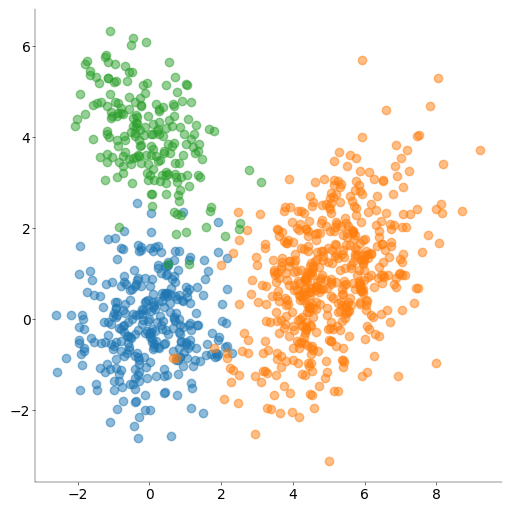

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
for label in np.unique(labels):
    ax.scatter(x[labels == label, 0], x[labels == label, 1], marker="o", alpha=0.5)

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [ ]:
def fit_mog(
    x: np.ndarray, n_clusters: int, niters: int = 10, random_seed: int = 2046
) -> tuple[np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    k: int
        Number of clusters

    niters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """

    np.random.seed(random_seed)
    n, _ = np.shape(x)

    ### Initialize the gausian mixture model with kmeans as first guess
    kmeans = KMeans(n_clusters=n_clusters).fit(x)
    # Intial gues from the kmeans for the centers or means!
    means = kmeans.cluster_centers_
    # Inital mixing coefficiant of the all cluster in n_clusters
    pi = np.ones(n_clusters) / n_clusters
    # Initial covariance matrix, identity marix with n_clusters rows
    cov = [np.eye(x.shape[1]) for _ in range(n_clusters)]

    for step in range(niters):
        ### E step calculation of gamma
        # creating empty list with size of n_samples and n_clusters. ex (1000, 3) 1000 samples and 3 clusters
        gamma_cluster = np.zeros((n, n_clusters))
        # go through n_cluster to calulate the upper term of the gamma:
        for cluster in range(n_clusters):
            gamma_cluster[:, cluster] = pi[cluster] * sp.stats.multivariate_normal.pdf(
                x, mean=means[cluster], cov=cov[cluster]
            )
        # creating the sum of gamma over all n_clusters
        gamma_all_clusters = np.sum(gamma_cluster, axis=1)
        # calculating the gamma with the upper term and the sum of gamma over all n_clusters
        gamma = gamma_cluster / gamma_all_clusters[:, np.newaxis]

        ### M step updating the mean, pi, cov with gamma
        for cluster in range(n_clusters):
            # create a new n_k, amount of samples in the gausian
            n_k = np.sum(gamma[:, cluster])
            # updating the new mixing coefficiant with the new samples
            pi_new = n_k / n
            # updating the new mean
            mean_new = np.sum(gamma[:, cluster][:, np.newaxis] * x, axis=0) / n_k
            # updating the covariance matrix
            cov_new = (
                np.dot(
                    (gamma[:, cluster][:, np.newaxis] * (x - mean_new)).T,
                    (x - mean_new),
                )
                / n_k
            )
            # updating the new mean, pi, cov
            means[cluster] = mean_new
            pi[cluster] = pi_new
            cov[cluster] = cov_new

        likelihoods = np.sum(np.log(gamma_all_clusters))
        print(f"Step {step}: Likelihood = {likelihoods}")
    labels = np.argmax(gamma, axis=1)
    return labels, means, cov, pi

Run Mixture of Gaussian on toy data

In [ ]:
mog_labels, m, S, p = fit_mog(x, 3, random_seed=0)

Step 0: Likelihood = -4161.640967667348
Step 1: Likelihood = -3976.382794489958
Step 2: Likelihood = -3970.72717583621
Step 3: Likelihood = -3968.9793042590163
Step 4: Likelihood = -3968.3380420379226
Step 5: Likelihood = -3968.088962886061
Step 6: Likelihood = -3967.988129514504
Step 7: Likelihood = -3967.9463183647795
Step 8: Likelihood = -3967.9287555888272
Step 9: Likelihood = -3967.9213251858137


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Plot toy data with cluster assignments and compare to original labels

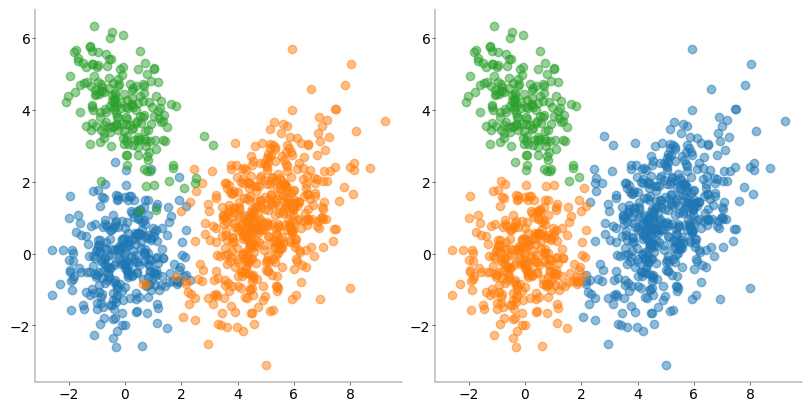

In [ ]:
mosaic = [["True", "MoG"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 4), layout="constrained")
for label in np.unique(labels):
    ax["True"].scatter(
        x[labels == label, 0], x[labels == label, 1], marker="o", alpha=0.5
    )
for label in np.unique(mog_labels):
    ax["MoG"].scatter(
        x[mog_labels == label, 0], x[mog_labels == label, 1], marker="o", alpha=0.5
    )

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 3 pts*



In [ ]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # insert your code here

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    pass

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (0.5 pts) and plot the result (0.5 pts)
# ---------------------------------------------------------------------------------------------------

K = range(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here

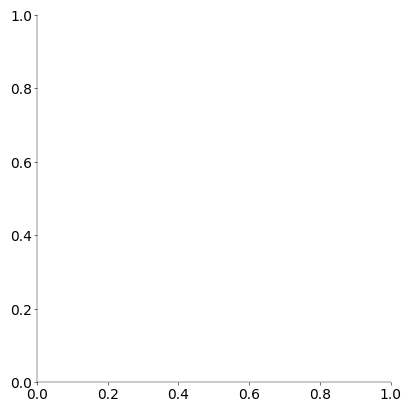

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
# plot BIC

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [ ]:
# ------------------------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (include plot) (1 pt)
# ------------------------------------------------------------------------------------------

K = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

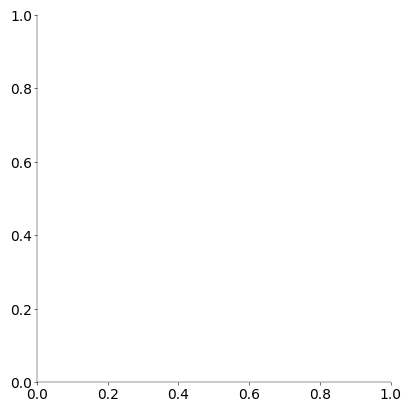

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot BIC

Refit model with lowest BIC and plot data points

In [ ]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")
# a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed)

lowest BIC: # cluster = 2


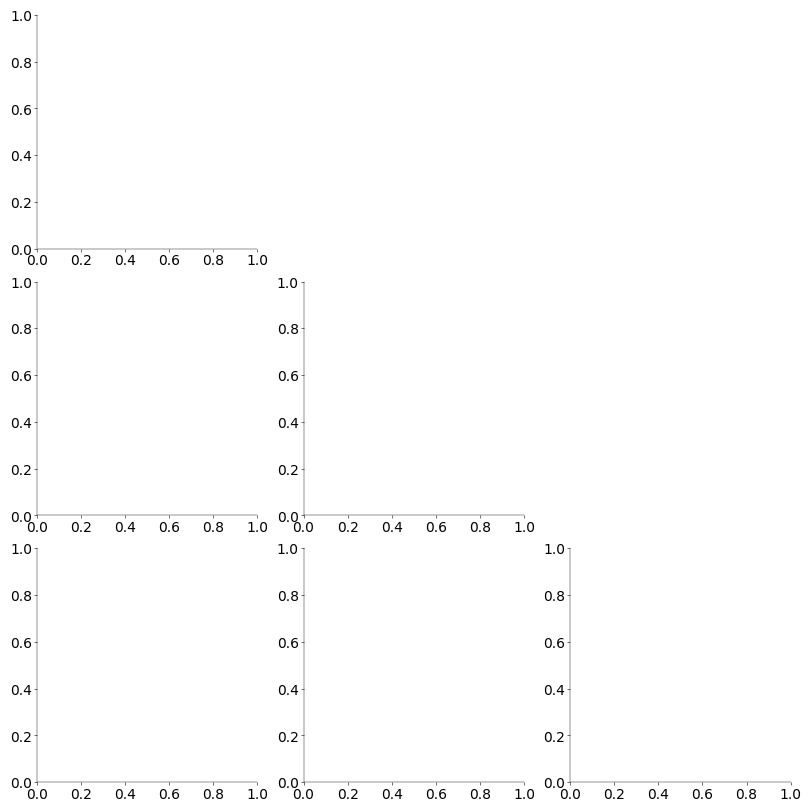

In [ ]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------


mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8), layout="constrained")

### Task 5: Cluster separation

Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.

*Grading: 4 pts*


In [ ]:
def separation(
    b: np.ndarray,
    m: np.ndarray,
    S: np.ndarray,
    p: np.ndarray,
    assignment: np.ndarray,
    nbins: int = 50,
):
    """Calculate cluster separation by LDA.

    proj, bins = separation(b, m, S, p, assignment)
    projects the data on the LDA axis for all pairs of clusters. The result
    is normalized such that the left (i.e. first) cluster has
    zero mean and unit variances. The LDA axis is estimated from the model.
    ---

    Parameters
    ----------
    b: np.array, (n_spikes, n_features)
        Features.

    m: np.array, (n_clusters, n_features)
        Means.

    S: np.array, (n_clusters, n_features, n_features)
        Covariance.

    p: np.array, (n_clusters, )
        Cluster weight.

    assignment: np.array, (n_spikes, )
        Cluster assignments / labels for each spike

    nbins: int
        Number of bins in a lda histogram.


    Returns
    -------

    proj: np.array, (n_bins, n_clusters, n_clusters)
        computed lda histo# Comparing the cells in particular

    bins: np.array, (n_bins)
        bin times relative to center    #bins x 1
    """

    # insert your code here

    # ---------------------------------------------------------------------
    # compute the optimal separating axes for each pair of clusters (2 pts)
    # ---------------------------------------------------------------------

    # -------------------------------------------
    # normalise according to first cluster (1 pt)
    # -------------------------------------------

    # --------------------------------------
    # plot histograms on optimal axis (1 pt)
    # --------------------------------------

    return proj, bins

In [ ]:
# proj, bins = separation(b, m, S, p, a)